# Libraries

In [83]:
pip install cartopy

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import os

# Clean data

In [62]:
# Seleccion de variables y nombre de las columnas
def change_column_names(df):
    columns = {
        "latitude": "latitude", "longitude": "longitude", "population_density": "population_density", "General class": "land_cover_type",
        "class": "land_cover_subtype", "Sub-class": "vegetation_percent", "date": "date", "ws": "wind_speed", "vpd": "vapor_pressure_deficit",
        "vap": "vapor_pressure", "tmin": "minimum_temperature", "tmax": "maximum_temperature", "swe": "snow_water_equivalent",
        "srad": "surface_shortwave_radiation", "soil": "soil_moisture", "q": "runoff", "ppt": "precipitation_accumulation",
        "pet": "Reference_evapotranspiration", "def": "climate_water_deficit", "aet": "actual_Evapotranspiration",
        "PDSI": "palmer_drought_severity_index", "brightness": "brightness_temperature", "scan": "scan_fire_size", "track": "track_fire_size",
        "confidence": "confidence", "frp": "fire_radiative_power", "daynight": "daynight", "type": "fire_type", "n_pixels": "n_pixels_ndvi",
        "vim": "ndvi", "vim_avg": "ndvi_long_term_average", "viq": "ndvi_anomaly_percent", "year": "year"
    }

    return df.dropna().rename(columns=columns)[columns.values()]

# Asignacion de valores de variable objetivo
def asign_class(value):
    if value in ["l", "n", "h"]:
        return value

    x = int(value)
    if 0 <= x < 30:
        return "l"
    elif 30 <= x < 80:
        return "n"

    return "h"

# Conversion de variables categoricas
def clean_dtypes(df, target_name):
    columns = df.drop(columns=[target_name]).select_dtypes(exclude=['number']).columns
    df[target_name] = df[target_name].astype(str)
    dict_values = {}

    for column_name in columns:
        nor_values = df[column_name].values
        cat_values = df[column_name].astype('category').cat.codes
        dict_values[column_name] = {f"{value[0]}":value[1] for value in set(zip(nor_values, cat_values))}
        df[column_name] = cat_values

    return df, dict_values

# Asignacion de una estacion
def set_season(date_value):
    if 3 <= date_value.month <= 5 or 9 <= date_value.month <= 11:
        return "rainy season"
    return "dry season"

def get_general_dataframe(df_values, target):
    df_values['seasons'] = df_values['date'].apply(set_season)
    df, dict_values = clean_dtypes(df_values.drop(columns=['date']), target)

    return df, dict_values

# models

In [63]:
def get_models_path():
    models_path = "./models"

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    return models_path

def get_root_directory():
    root_directory_path = "./datasets"

    if not os.path.exists(root_directory_path):
        os.makedirs(root_directory_path)

    return root_directory_path

# Medidas del modelo
def get_info_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')

    return accuracy, precision, recall

# Entrenamiento del modelo
def get_avg_training(X, y, model):
    avg_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy, precision, recall = get_info_model(y_test, y_pred)
        avg_scores.append([accuracy, precision, recall])

    avg_scores = np.array(avg_scores)
    accuracy_avg = np.mean(avg_scores[:, 0])
    precision_avg = np.mean(avg_scores[:, 1])
    recall_avg = np.mean(avg_scores[:, 2])

    return accuracy_avg, precision_avg, recall_avg

# Creacion de ambos modelos
def create_models(df, target):
    X = df.drop(columns=[target]).values
    y = df[target].values

    random_forest_model = RandomForestClassifier(n_estimators=120, max_depth=10, class_weight="balanced", random_state=42)
    random_forest_info = get_avg_training(X, y, random_forest_model)

    bayesian_model = BernoulliNB()
    bayesian_info = get_avg_training(X, y, bayesian_model)

    return random_forest_model, random_forest_info, bayesian_model, bayesian_info

def save_model(dict_values, model, models_path):
    joblib.dump(model, f"{models_path}/model.joblib")
    joblib.dump(dict_values, f"{models_path}/dict_values.joblib")

# Describing data

In [64]:
models_path = get_models_path()
root_directory_path = get_root_directory()

In [65]:
df_final = pd.read_pickle(f'{root_directory_path}/final_dataset.pkl')

In [66]:
target = "confidence"

In [67]:
df_final[target] = df_final[target].apply(asign_class)
df_final = change_column_names(df_final)

In [68]:
df_final.head()

,latitude,longitude,population_density,land_cover_type,land_cover_subtype,vegetation_percent,date,wind_speed,vapor_pressure_deficit,vapor_pressure,...,track_fire_size,confidence,fire_radiative_power,daynight,fire_type,n_pixels_ndvi,ndvi,ndvi_long_term_average,ndvi_anomaly_percent,year
0,8.9371,-73.5798,14.648424,Terra Firma,Tree cover,8m trees,2002-07-01,2.33,1.05,2.763,...,1.1,n,7.7,D,presumed vegetation fire,18.0,0.7971,0.7946,100.3005,2002
1,4.7785,-75.8046,443.014130,Terra Firma,Tree cover,5m trees,2002-07-01,1.09,0.91,2.036,...,1.0,n,3.9,D,presumed vegetation fire,1.0,0.7973,0.7787,102.2467,2002
2,10.2584,-74.0905,13.135686,Terra Firma,Dense short vegetation,100% short vegetation cover,2002-07-01,2.79,1.24,2.937,...,1.1,n,23.2,D,presumed vegetation fire,13.0,0.7110,0.7702,92.7813,2002
3,10.4153,-74.3193,9.273766,Terra Firma,Dense short vegetation,100% short vegetation cover,2002-07-01,3.08,1.15,3.000,...,1.1,n,9.6,D,presumed vegetation fire,10.0,0.7715,0.8110,95.4165,2002
4,9.6186,-74.5987,15.801455,Terra Firma,Tree cover,6m trees,2002-07-01,2.10,1.13,2.989,...,1.0,n,9.3,D,presumed vegetation fire,16.0,0.7413,0.7151,103.4241,2002


In [69]:
df_final.to_csv(f'{root_directory_path}/final_dataset.csv', index=False)

In [70]:
df_final_cleanned, dict_values = get_general_dataframe(df_final.copy(), target)
df_final_cleanned_codes = df_final_cleanned.copy()
df_final_cleanned_codes[target] = df_final_cleanned_codes[target].astype('category').cat.codes

In [71]:
df_final_cleanned[target].value_counts()

confidence
n    1521844
h     208636
l     100449
Name: count, dtype: int64

In [72]:
df_final_cleanned.columns

Index(['latitude', 'longitude', 'population_density', 'land_cover_type',
       'land_cover_subtype', 'vegetation_percent', 'wind_speed',
       'vapor_pressure_deficit', 'vapor_pressure', 'minimum_temperature',
       'maximum_temperature', 'snow_water_equivalent',
       'surface_shortwave_radiation', 'soil_moisture', 'runoff',
       'precipitation_accumulation', 'Reference_evapotranspiration',
       'climate_water_deficit', 'actual_Evapotranspiration',
       'palmer_drought_severity_index', 'brightness_temperature',
       'scan_fire_size', 'track_fire_size', 'confidence',
       'fire_radiative_power', 'daynight', 'fire_type', 'n_pixels_ndvi',
       'ndvi', 'ndvi_long_term_average', 'ndvi_anomaly_percent', 'year',
       'seasons'],
      dtype='object')

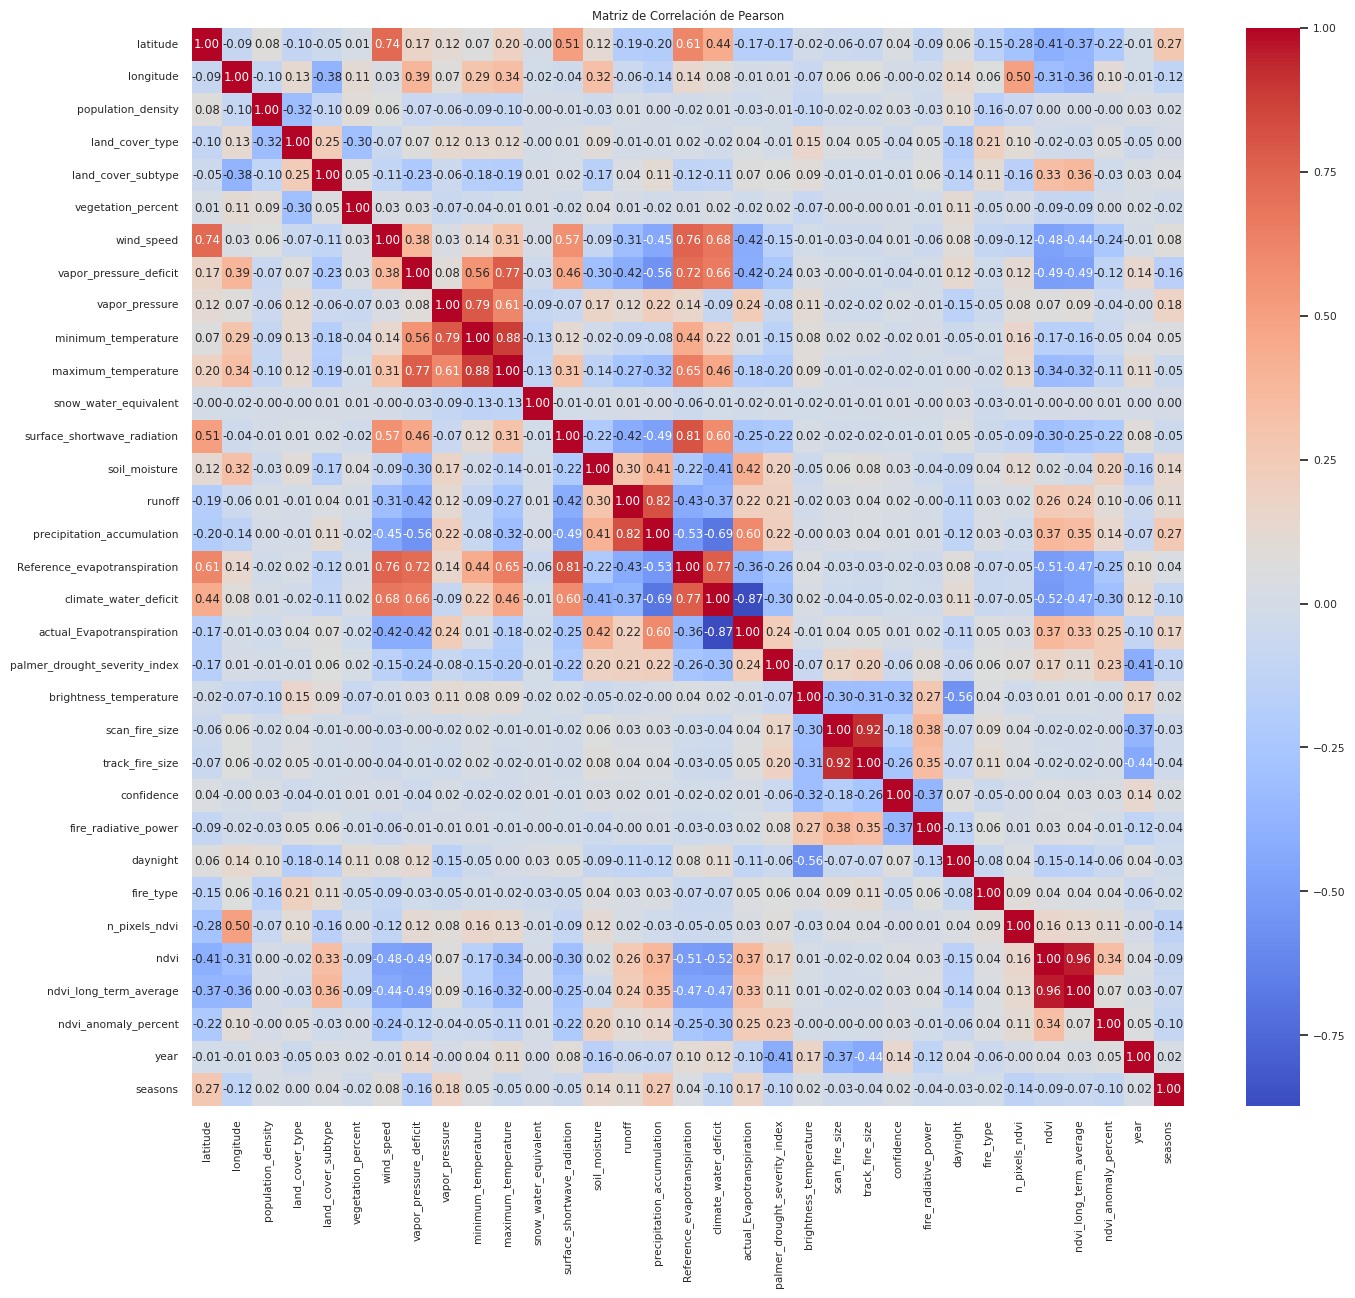

In [73]:
corr = df_final_cleanned_codes.corr()
plt.figure(figsize=(16, 14))
sns.set(font_scale=0.7)

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Pearson')
plt.show()

In [74]:
# Se establece un umbral de correlacion
threshold = 0.85
correlation_matrix = corr.abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
reduced_df = df_final_cleanned.drop(columns=to_drop + ["year"]) # Se quita 1 de 2 columnas altamente correlacionadas

# Creating model

In [75]:
reduced_df.columns

Index(['latitude', 'longitude', 'population_density', 'land_cover_type',
       'land_cover_subtype', 'vegetation_percent', 'wind_speed',
       'vapor_pressure_deficit', 'vapor_pressure', 'minimum_temperature',
       'snow_water_equivalent', 'surface_shortwave_radiation', 'soil_moisture',
       'runoff', 'precipitation_accumulation', 'Reference_evapotranspiration',
       'climate_water_deficit', 'palmer_drought_severity_index',
       'brightness_temperature', 'scan_fire_size', 'confidence',
       'fire_radiative_power', 'daynight', 'fire_type', 'n_pixels_ndvi',
       'ndvi', 'ndvi_anomaly_percent', 'seasons'],
      dtype='object')

In [76]:
random_forest_model, random_forest_info, bayesian_model, bayesian_info = create_models(reduced_df, target)

In [77]:
rf_accuracy, rf_precision, rf_recall = random_forest_info

print("Random Forest")
print(f"rf_accuracy={rf_accuracy}")
print(f"rf_precision={rf_precision}")
print(f"rf_recall={rf_recall}")

Random Forest
rf_accuracy=0.7556530030182472
rf_precision=0.7556530030182472
rf_recall=0.7556530030182472


In [78]:
bm_accuracy, bm_precision, bm_recall = bayesian_info

print("Bayesian Model")
print(f"bm_accuracy={bm_accuracy}")
print(f"bm_precision={bm_precision}")
print(f"bm_recall={bm_recall}")

Bayesian Model
bm_accuracy=0.8311911594294987
bm_precision=0.8311911594294987
bm_recall=0.8311911594294987


In [79]:
random_forest_score = np.mean(np.array(random_forest_info))
bayesian_score = np.mean(np.array(bayesian_info))

In [80]:
rf_probs = random_forest_model.feature_importances_ # Influencias de variables en el modelo

In [81]:
for [column, rf_prob] in list(sorted(zip(reduced_df.drop(columns=[target]), rf_probs), key = lambda x: x[1]))[::-1]:
    print(f"{column} = {rf_prob}")

brightness_temperature = 0.36202780466637774
fire_radiative_power = 0.2937663762468796
scan_fire_size = 0.20287569623089033
daynight = 0.054567602146605665
latitude = 0.00895284247024199
ndvi = 0.008261858800260612
vapor_pressure_deficit = 0.006946286375307719
population_density = 0.00629527710860264
palmer_drought_severity_index = 0.004788458765437019
vapor_pressure = 0.004545927035112497
longitude = 0.004366298377755412
climate_water_deficit = 0.004303777353953035
Reference_evapotranspiration = 0.004217992924209026
wind_speed = 0.0041862313965090655
soil_moisture = 0.004061789459452185
fire_type = 0.0032812867010409844
land_cover_type = 0.003002199365045934
ndvi_anomaly_percent = 0.002851034941293105
precipitation_accumulation = 0.0026387402366453688
runoff = 0.0026008059000244533
land_cover_subtype = 0.002433347104049935
n_pixels_ndvi = 0.002407652526812699
minimum_temperature = 0.002283505292352007
seasons = 0.0017638290937980192
surface_shortwave_radiation = 0.0013552491838400374


In [82]:
most_influyent_index = np.argmax(np.abs(rf_probs))
most_influyent_name = reduced_df.drop(columns=[target]).columns[most_influyent_index]
most_influyent_value = rf_probs[most_influyent_index]

print(f"{most_influyent_name} = {most_influyent_value}")

brightness_temperature = 0.36202780466637774


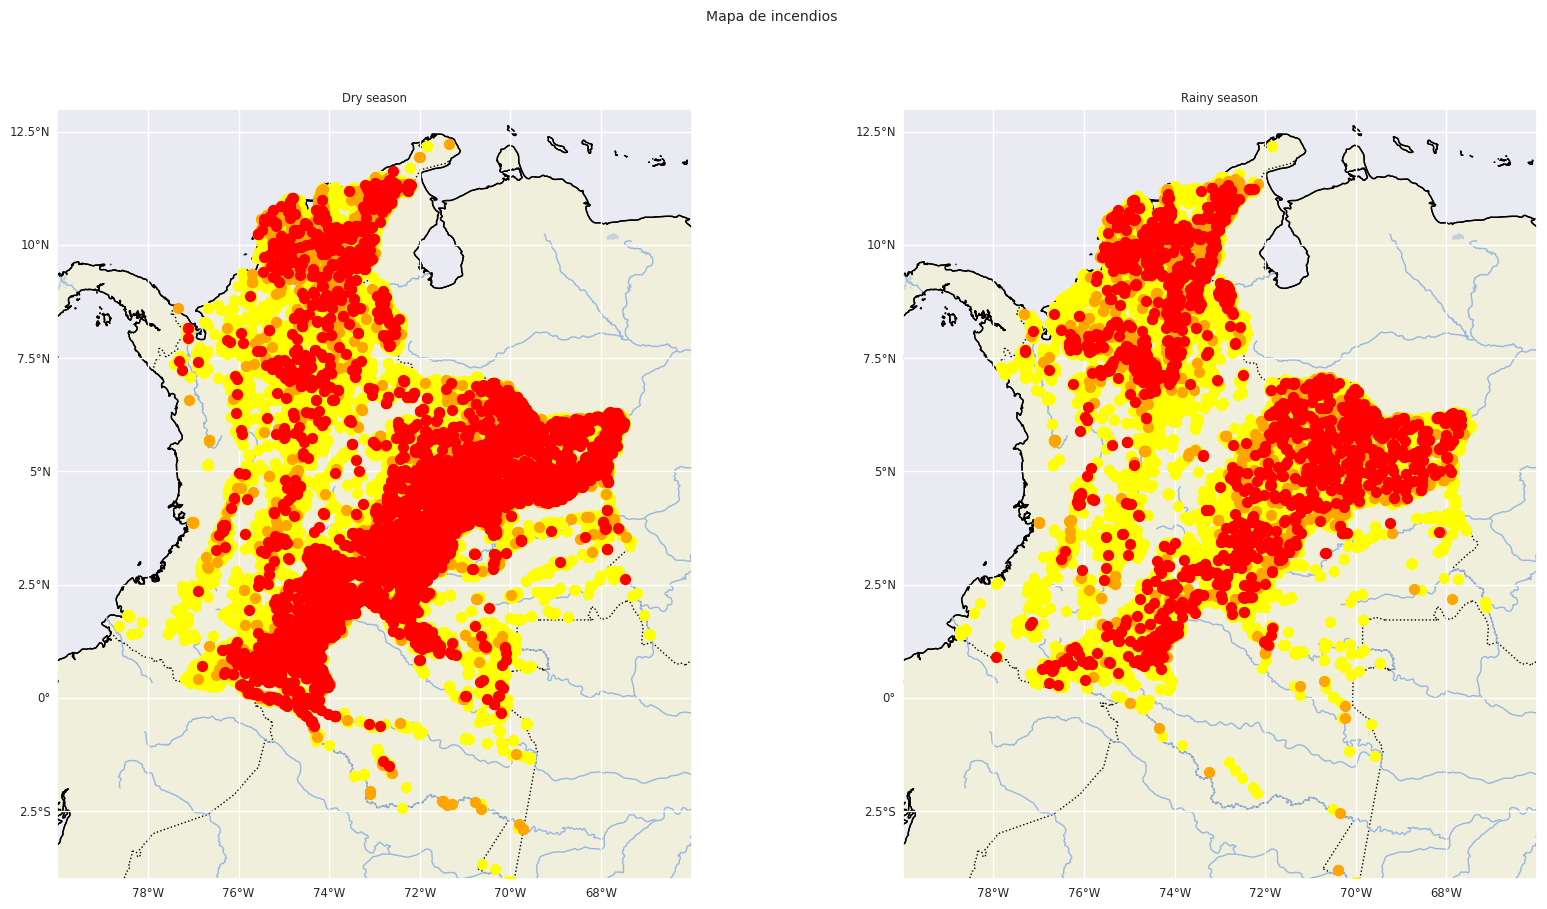

In [84]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [-80, -66, -4, 13]

# Configurar el primer mapa
ax1.set_extent(extent)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.RIVERS)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
ax1.set_title('Dry season')

# Configurar el segundo mapa
ax2.set_extent(extent)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.LAND, edgecolor='black')
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(cfeature.RIVERS)
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
ax2.set_title('Rainy season')

# confidences (l, n, h)
confidences = df_final_cleanned[target].unique()
colors = ["yellow", "orange", "red"]
year = 2022

for color, conf in zip(colors, confidences):
    # dry season
    coords = df_final_cleanned[
        (df_final_cleanned[target] == conf) &
        (df_final_cleanned["seasons"] == 0) &
        (df_final_cleanned["year"] == year)][['longitude', 'latitude']].values
    lon_values, lat_values = coords[:, 0], coords[:, 1]
    ax1.scatter(lon_values, lat_values, color=color, s=50, transform=ccrs.PlateCarree(), zorder=5)

    # rainy season
    coords = df_final_cleanned[
        (df_final_cleanned[target] == conf) &
        (df_final_cleanned["seasons"] == 1) &
        (df_final_cleanned["year"] == year)][['longitude', 'latitude']].values
    lon_values, lat_values = coords[:, 0], coords[:, 1]
    ax2.scatter(lon_values, lat_values, color=color, s=50, transform=ccrs.PlateCarree(), zorder=5)

# Mostrar el mapa
plt.suptitle('Mapa de incendios')
plt.show()

In [85]:
model = random_forest_model if random_forest_score >= bayesian_score else bayesian_model

In [86]:
save_model(dict_values, model, models_path)

# Example of the model

In [87]:
model = joblib.load(f"{models_path}/model.joblib")
dict_values = joblib.load(f"{models_path}/dict_values.joblib")

In [88]:
dict_values

{'land_cover_type': {'Not registered': 2,
  'Ocean': 3,
  'Terra Firma': 6,
  'Open surface water': 4,
  'Snow/ice': 5,
  'Built-up': 0,
  'Wetland': 7,
  'Cropland': 1},
 'land_cover_subtype': {'Not registered': 3,
  'Ocean': 4,
  'Tree cover': 10,
  'True desert': 11,
  'Dense short vegetation': 2,
  'Built-up': 0,
  'Snow/ice': 8,
  'Salt pan': 6,
  'Sparse vegetation': 9,
  'Semi-arid': 7,
  'Open surface water': 5,
  'Cropland': 1},
 'vegetation_percent': {'Cropland': 58,
  '63% short vegetation cover': 39,
  '60-69% of year': 38,
  '91% short vegetation cover': 53,
  '24m trees': 20,
  '59% short vegetation cover': 36,
  '31% short vegetation cover': 25,
  '20m trees': 15,
  '75% short vegetation cover': 45,
  '70-79% of year': 43,
  '47% short vegetation cover': 31,
  '19m trees': 13,
  '51% short vegetation cover': 34,
  '13m trees': 5,
  '17m trees': 10,
  '87% short vegetation cover': 50,
  '12m trees': 4,
  '40-49% of year': 29,
  '14m trees': 6,
  '23m trees': 19,
  '18m tr

In [89]:
# Medellin
ff_value = {
    'latitude': 6.25184,
    'longitude': -75.56359,
    'population_density': 19134.373047,
    'land_cover_type': 'Terra Firma',
    'land_cover_subtype': 'Tree cover',
    'vegetation_percent': '35% short vegetation cover',
    'wind_speed': 1.3,
    'vapor_pressure_deficit': 0.82,
    'vapor_pressure': 1.913,
    'minimum_temperature': 289.45,
    'snow_water_equivalent': 0.0,
    'surface_shortwave_radiation': 207.8,
    'soil_moisture': 36,
    'runoff': 108.4,
    'precipitation_accumulation': 221.7,
    'Reference_evapotranspiration': 113.3,
    'climate_water_deficit': 0.0,
    'palmer_drought_severity_index': -3.4,
    'brightness_temperature': 321.6,
    'scan_fire_size': 1.3,
    'fire_radiative_power': 9.0,
    'daynight': 'D',
    'fire_type': 'presumed vegetation fire',
    'n_pixels_ndvi': 15.0,
    'ndvi': 0.7695,
    'ndvi_anomaly_percent': 100.7927,
    'seasons': 'dry season'
}

In [90]:
for key in dict_values:
    old_value = ff_value[key]
    new_value = dict_values[key][old_value]
    ff_value[key] = new_value

In [91]:
mp_values = np.array([value for _, value in ff_value.items()]).reshape(1, -1)

In [92]:
value_predicted = model.predict(mp_values)[0]

In [93]:
if value_predicted == "l":
    print("0 - 30% de probabilidad de que ocurra un incendio")
elif value_predicted == "n":
    print("30 - 80% de probabilidad de que ocurra un incendio")
elif value_predicted == "h":
    print("80 - 100% de probabilidad de que ocurra un incendio")

30 - 80% de probabilidad de que ocurra un incendio
